# Overview
We will be creating an argumentative chatbot based on this dataset: https://nlds.soe.ucsc.edu/iac 

# 1. Create the raw input-output pairs from the dataset 

We begin by converting the arguments dataset into a format useful to us. The dataset contains various features, but we're primarily concerned with creating parent-child (statement-response or input-output) post pairs. Because the posts are not necessarily replying to their direct predecessor in the discussion (and thus in the JSON), we will have to keep track of the post id and parent id for each post to create pairings.

In [1]:
import json
import os
import re
import time
import pickle

In [2]:
id_to_text = {}
parent_to_child_ids = []
my_data_dir = "./data/"
my_data_dir_full = os.path.join(os.getcwd(), my_data_dir)
if not os.path.isdir(my_data_dir_full):
    os.mkdir(my_data_dir_full)
build_pairs = True

if build_pairs:
    data_dir = "./iac_v1.1/data/fourforums/discussions/"
    
    discussion_filepaths = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]

    print("Building metadata (Part 1/2)...")
    curr_file_num = 0
    start_time = time.time()
    for discussion_filepath in discussion_filepaths:
        if curr_file_num % (len(discussion_filepaths)//10) == 0:
            print("Processing file {} of {}...".format(curr_file_num, len(discussion_filepaths)))
        curr_file_num += 1
        with open(discussion_filepath, 'r') as discussion_file:
            discussion = json.load(discussion_file)[0]
            for post in discussion:
                post_id = post[0]
                post_parent_id = post[5]
                post_text = post[3]
                id_to_text[post_id] = post_text
                if post_parent_id:
                    parent_to_child_ids.append((post_parent_id, post_id))

    print("Saving metadata (Part 2/2)...")
    with open(os.path.join(my_data_dir, 'id_to_text.pkl'), 'wb') as id_to_text_file:
        pickle.dump(id_to_text, id_to_text_file, pickle.HIGHEST_PROTOCOL)
        
    with open(os.path.join(my_data_dir, 'parent_to_child_ids.pkl'), 'wb') as parent_to_child_ids_file:
        pickle.dump(parent_to_child_ids, parent_to_child_ids_file, pickle.HIGHEST_PROTOCOL)

    print("Finished processing files!\nTotal elapsed time: {}".format(time.time() - start_time))

Building metadata (Part 1/2)...
Processing file 0 of 11800...
Processing file 1180 of 11800...
Processing file 2360 of 11800...
Processing file 3540 of 11800...
Processing file 4720 of 11800...
Processing file 5900 of 11800...
Processing file 7080 of 11800...
Processing file 8260 of 11800...
Processing file 9440 of 11800...
Processing file 10620 of 11800...
Saving metadata (Part 2/2)...
Finished processing files!
Total elapsed time: 6.684291124343872


# 2. Convert raw input-output pairs into feedable format for training

In [3]:
import spacy
import torchtext
import pandas as pd
import sklearn
import sklearn.model_selection
import matplotlib.pyplot as plt 
import numpy as np

In [4]:
with open(os.path.join(my_data_dir, 'id_to_text.pkl'), 'rb') as id_to_text_file:
    id_to_text = pickle.load(id_to_text_file)

with open(os.path.join(my_data_dir, 'parent_to_child_ids.pkl'), 'rb') as parent_to_child_ids_file:
    parent_to_child_ids = pickle.load(parent_to_child_ids_file)

Mean post length: 193.52459662557845
Min post length: 1
Max post length: 12347
Post length standard deviation: 292.1808739716809
Percentage of posts shorter than 200 words: 0.717584155780335


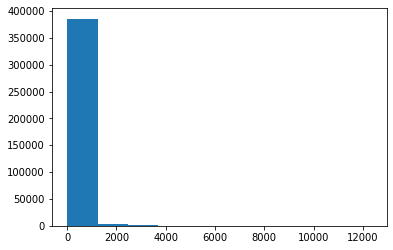

In [5]:
post_lengths = {post_id: len(post.split(' ')) for post_id, post  in id_to_text.items()}

print("Mean post length: {}".format(np.mean(list(post_lengths.values()))))
print("Min post length: {}".format(np.min(list(post_lengths.values()))))
print("Max post length: {}".format(np.max(list(post_lengths.values()))))
print("Post length standard deviation: {}".format(np.std(list(post_lengths.values()))))

max_post_length = 200
print("Percentage of posts shorter than {} words: {}".format(max_post_length, np.mean([post_length < max_post_length for post_length in post_lengths.values()])))
plt.hist(list(post_lengths.values()))
plt.show()

Mean ratio: 2.9412882069147175
Min ratio: 0.00038299502106472615
Max ratio: 4746.0
Ratio standard deviation: 19.61325095885775
Percentage of ratios greater than 3: 0.16417087177754788
Percentage of ratios less than 0.33: 0.11400776977809683


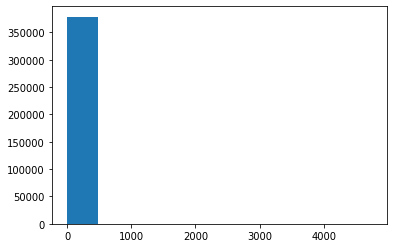

In [6]:
post_length_ratios = [post_lengths[parent_id]/post_lengths[child_id] for parent_id, child_id in parent_to_child_ids]

print("Mean ratio: {}".format(np.mean(post_length_ratios)))
print("Min ratio: {}".format(np.min(post_length_ratios)))
print("Max ratio: {}".format(np.max(post_length_ratios)))
print("Ratio standard deviation: {}".format(np.std(post_length_ratios)))

max_post_length_ratio = 3
min_post_length_ratio = 0.33
print("Percentage of ratios greater than {}: {}".format(max_post_length_ratio, np.mean([post_length_ratio > max_post_length_ratio for post_length_ratio in post_length_ratios])))
print("Percentage of ratios less than {}: {}".format(min_post_length_ratio, np.mean([post_length_ratio < min_post_length_ratio for post_length_ratio in post_length_ratios])))
plt.hist(post_length_ratios)
plt.show()        

In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
def light_tokenizer(post):
    return [token.text for token in nlp(post, disable=['parser', 'tagger', 'ner'])]

post_field = torchtext.data.Field(tokenize=light_tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)

In [9]:
build_csv = True

if build_csv:
    with open(os.path.join(my_data_dir, 'id_to_text.pkl'), 'rb') as id_to_text_file:
        id_to_text = pickle.load(id_to_text_file)

    with open(os.path.join(my_data_dir, 'parent_to_child_ids.pkl'), 'rb') as parent_to_child_ids_file:
        parent_to_child_ids = pickle.load(parent_to_child_ids_file)

    pairs = {'parent_post': [], 'child_post': []}
    for parent_post_id, child_post_id in parent_to_child_ids:
        parent_post_length = len(id_to_text[parent_post_id].split(' '))
        child_post_length = len(id_to_text[child_post_id].split(' '))
        
        if parent_post_length < max_post_length and child_post_length < max_post_length and parent_post_length/child_post_length <= max_post_length_ratio and parent_post_length/child_post_length >= min_post_length_ratio:
            # TODO: check for large difference in post length
            pairs['parent_post'].append(id_to_text[parent_post_id])
            pairs['child_post'].append(id_to_text[child_post_id])

    print("Percentage of data retained: {}".format(len(pairs['parent_post']) *100 / len(parent_to_child_ids)))
    pairs_df = pd.DataFrame(pairs, columns=['parent_post', 'child_post'])
    train, test = sklearn.model_selection.train_test_split(pairs_df, test_size=0.2)

    train.to_csv(os.path.join(my_data_dir, 'train.csv'), index=False)
    test.to_csv(os.path.join(my_data_dir, 'test.csv'), index=False)

Percentage of data retained: 45.765945991596816


In [10]:
print("Building datasets...")
dataset_start_time = time.time()
pair_fields = [('parent_post', post_field), ('child_post', post_field)]
train_set, test_set = torchtext.data.TabularDataset.splits(path=my_data_dir, train='train.csv', test='test.csv', format='csv', fields=pair_fields)
print("Datasets built! Time elapsed: {}".format(time.time()-dataset_start_time))

print("Building vocabulary...")
vocab_start_time = time.time()
post_field.build_vocab(train_set, min_freq=2)
print("Vocabulary built! Time elapsed: {}".format(time.time()-vocab_start_time))
print("Vocabulary size: {}".format(len(post_field.vocab)))

Building datasets...
Datasets built! Time elapsed: 198.88171911239624
Building vocabulary...
Vocabulary built! Time elapsed: 4.872278928756714
Vocabulary size: 91919


In [11]:
import torch

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu_device = torch.device('cpu')
train_set_iterator, test_set_iterator = torchtext.data.BucketIterator.splits((train_set, test_set), batch_size=16, device=device, shuffle=True, sort_key=lambda pair: len(pair.parent_post))

# 3. Create the seq2seq model

In [13]:
import random

In [14]:
class Seq2SeqEncoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_layer_size, num_hidden_layers, dropout_rate):
        super(Seq2SeqEncoder, self).__init__()
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.rnn = torch.nn.LSTM(embedding_size, hidden_layer_size, num_hidden_layers, dropout=dropout_rate)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
    def forward(self, encoder_input):
        output, (hidden_state, cell) = self.rnn(self.dropout(self.embedding(encoder_input)))
        return hidden_state, cell
        
class Seq2SeqDecoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_layer_size, num_hidden_layers, output_size, dropout_rate):
        super(Seq2SeqDecoder, self).__init__()
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.rnn = torch.nn.LSTM(embedding_size, hidden_layer_size, num_hidden_layers, dropout=dropout_rate)
        self.output_size = output_size
        self.out = torch.nn.Linear(hidden_layer_size, output_size)
        self.dropout = torch.nn.Dropout(dropout_rate)
    
    def forward(self, decoder_input, hidden_state, cell):
        output, (hidden_state, cell) = self.rnn(self.dropout(self.embedding(decoder_input.unsqueeze(0))), (hidden_state, cell))
        return self.out(output.squeeze(0)), hidden_state, cell 
    
class Seq2Seq(torch.nn.Module):
    def __init__(self, encoder_net, decoder_net):
        super(Seq2Seq, self).__init__()
        self.encoder_net = encoder_net
        self.decoder_net = decoder_net
        
    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = target.shape[1]
        max_len = target.shape[0]
        vocab_size = self.decoder_net.output_size
        s2s_outputs = torch.zeros(max_len, batch_size, vocab_size).to(device)
        
        hidden_state, cell = self.encoder_net(source)
        decoder_input = target[0,:]
        for token_index in range(1, max_len):
            output, hidden_state, cell = self.decoder_net(decoder_input, hidden_state, cell)
            s2s_outputs[token_index] = output
            if random.random() < teacher_forcing_ratio:
                decoder_input = target[token_index]
            else:
                decoder_input = output.argmax(1)
        
        return s2s_outputs

In [15]:
# Hyperparameters
input_size = output_size = len(post_field.vocab)
embedding_size = 128
hidden_layer_size = 256
num_hidden_layers = 2
dropout_rate = 0.5

# print(torch.cuda.memory_allocated(device=0)/(10**9))
encoder_net = Seq2SeqEncoder(input_size, embedding_size, hidden_layer_size, num_hidden_layers, dropout_rate)
# print(torch.cuda.memory_allocated(device=0)/(10**9))
decoder_net = Seq2SeqDecoder(input_size, embedding_size, hidden_layer_size, num_hidden_layers, output_size, dropout_rate)
# print(torch.cuda.memory_allocated(device=0)/(10**9))
seq2seq_net = Seq2Seq(encoder_net, decoder_net).to(device)

# 4. Train the seq2seq model

In [16]:
optimizer = torch.optim.Adam(seq2seq_net.parameters())
padding_index = post_field.vocab.stoi['<pad>']
loss_function = torch.nn.CrossEntropyLoss(ignore_index=padding_index)

In [17]:
models_directory = os.path.join(os.getcwd(), my_data_dir, 'models/')
if not os.path.isdir(models_directory):
    os.mkdir(models_directory)

run_name = "v3-small"
run_models_directory = os.path.join(os.getcwd(), my_data_dir, 'models/{}'.format(run_name))
if not os.path.isdir(run_models_directory):
    os.mkdir(run_models_directory)

In [18]:
max_clip = 1
def train(seq2seq_net, train_set_iterator, optimizer, loss_function, max_clip, writer, epoch_num):
    seq2seq_net.train()
    total_loss = 0
    time_train = time.time()
    inner_min_loss = float('inf')
    iterator_length = len(train_set_iterator)
    for i, batch in enumerate(train_set_iterator):
        parent_post = batch.parent_post
        child_post = batch.child_post
        if i % 10 == 0:
            print('train: {} of {} in epoch {}'.format(i, iterator_length, epoch_num))
#         print('1', torch.cuda.memory_allocated(device=0)/(10**9))
        optimizer.zero_grad()
        response = seq2seq_net(parent_post, child_post, 0.5)
#         print('2', torch.cuda.memory_allocated(device=0)/(10**9))
        response = response[1:].view(-1, response.shape[-1])
        child_post = child_post[1:].view(-1)
        
        loss = loss_function(response, child_post)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(seq2seq_net.parameters(), max_clip)
        optimizer.step()
        total_loss += loss.item()
        inner_loss_scalar = loss.detach().to(cpu_device).numpy().squeeze()
#         print('3', torch.cuda.memory_allocated(device=0)/(10**9))
#         response = response.detach()
#         del response
        if i % (len(train_set_iterator) // 10) == 0 or i == len(train_set_iterator) - 1:
            writer.add_scalar('Loss/train', inner_loss_scalar, epoch_num*len(train_set_iterator)+i)
            if (inner_loss_scalar < inner_min_loss):
                torch.save(seq2seq_net.state_dict(), os.path.join(my_data_dir, 'models/{}/best-inner-model-train-{}.pt'.format(run_name, epoch_num)))
                torch.save(encoder_net.state_dict(), os.path.join(my_data_dir, 'models/{}/best-encoder-inner-model-train-{}.pt'.format(run_name, epoch_num)))
                torch.save(decoder_net.state_dict(), os.path.join(my_data_dir, 'models/{}/best-decoder-inner-model-train-{}.pt'.format(run_name, epoch_num)))
                lowest_loss_train = inner_loss_scalar
            
        print("total time for epoch so far: {}".format(time.time() - time_train))
    
    return total_loss/len(train_set_iterator)

def test(seq2seq_net, test_set_iterator, loss_function, writer, epoch_num):
    seq2seq_net.eval()
    total_loss = 0
    time_test = time.time()
    iterator_length = len(test_set_iterator)
    for i, batch in enumerate(test_set_iterator):
        parent_post = batch.parent_post
        child_post = batch.child_post
        
        if i % 10 == 0:
            print('test: {} of {} in epoch {}'.format(i, iterator_length, epoch_num))
#         print('1', torch.cuda.memory_allocated(device=0)/(10**9))
        response = seq2seq_net(parent_post, child_post, 0)
#         print('2', torch.cuda.memory_allocated(device=0)/(10**9))
        response = response[1:].view(-1, response.shape[-1])
        child_post = child_post[1:].view(-1)
        
        loss = loss_function(response, child_post)
        total_loss += loss.item()
        print("total time for epoch so far: {}".format(time.time() - time_train))
#         response = response.detach()
#         del response
#         print('3', torch.cuda.memory_allocated(device=0)/(10**9))
        if i % (len(test_set_iterator) // 10) == 0:
            writer.add_scalar('Loss/test', loss.detach().to(cpu_device).numpy().squeeze(), epoch_num*len(test_set_iterator)+i)
        
    return total_loss/len(test_set_iterator)

In [19]:
import torch.utils.tensorboard

In [ ]:
writer = torch.utils.tensorboard.SummaryWriter(log_dir=os.path.join(my_data_dir, "runs/{}".format(run_name)))
num_epochs = 10

lowest_loss_train = float('inf')
lowest_loss_test = float('inf')
print(torch.cuda.memory_allocated(device=0)/(10**9))
print("Beginning training...")
training_start_time = time.time()
for epoch in range(num_epochs):
    print("Starting epoch {}...".format(epoch))
    
    epoch_start_time = time.time()
    loss_train = train(seq2seq_net, train_set_iterator, optimizer, loss_function, max_clip, writer, epoch)
    print("epoch train", torch.cuda.memory_allocated(device=0)/(10**9))
    loss_test = test(seq2seq_net, test_set_iterator, loss_function, writer, epoch)
    print("epoch test", torch.cuda.memory_allocated(device=0)/(10**9))
    loss_train_scalar = loss_train.detach().to(cpu_device).numpy().squeeze()
    loss_test_scalar = loss_test.detach().to(cpu_device).numpy().squeeze()
    writer.add_scalar('Loss/train', loss_train_scalar, epoch)
    writer.add_scalar('Loss/test', loss_test_scalar, epoch)
    
    print("Epoch training duration: {}".format(time.time()-epoch_start_time))
    print("Updating models...")
    
    if loss_train_scalar <= lowest_loss_train:
        torch.save(seq2seq_net.state_dict(), os.path.join(my_data_dir, 'models/{}/best-model-train.pt'.format(run_name)))
        torch.save(encoder_net.state_dict(), os.path.join(my_data_dir, 'models/{}/best-encoder-model-train.pt'.format(run_name)))
        torch.save(decoder_net.state_dict(), os.path.join(my_data_dir, 'models/{}/best-decoder-model-train.pt'.format(run_name)))
        lowest_loss_train = loss_train_scalar
    if loss_test_scalar <= lowest_loss_test:
        torch.save(seq2seq_net.state_dict(), os.path.join(my_data_dir, 'models/{}/best-model-test.pt'.format(run_name)))
        torch.save(encoder_net.state_dict(), os.path.join(my_data_dir, 'models/{}/best-encoder-model-test.pt'.format(run_name)))
        torch.save(decoder_net.state_dict(), os.path.join(my_data_dir, 'models/{}/best-decoder-model-test.pt'.format(run_name)))
        lowest_loss_test = loss_test_scalar
    
    print("Total elapsed time: {}".format(time.time()-training_start_time))
    

print("Finished training!")